In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Goal: predict whether a user will purchase an item using an e-commerce dataset

Loading data: online retail dataset from Kaggle

In [185]:
retail_data = pd.read_csv('data.csv', encoding='ISO-8859-1')
retail_data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [186]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Exploring and cleaning the data:

InvoiceNo are either numeric (completed transaction), or start with C or A (canceled or adjusted transactions)

We will remove canceled and adjusted transactions, keeping only completed transactions

In [187]:
# Number of unique transactions
print(f'Number of unique transactions: {retail_data.InvoiceNo.unique().shape[0]:5d}')

# Transactions with missing InvoiceNo
missing_invoices = retail_data[retail_data['InvoiceNo'].isna()]
print(f"Number of transactions with missing InvoiceNo: {missing_invoices.shape[0]:1d}")

# Canceled or adjusted transactions (non-numeric InvoiceNo ; starting with C or A)
canceled_invoices = retail_data[~retail_data['InvoiceNo'].str.isnumeric()]
print(f"Number of unique canceled or adjusted transactions: {canceled_invoices['InvoiceNo'].unique().shape[0]:5d}")

# Remove canceled or adjusted transactions
cleaned_retail_data = retail_data[retail_data['InvoiceNo'].str.isnumeric()].copy()
cleaned_retail_data['InvoiceNo'] = cleaned_retail_data['InvoiceNo'].astype(int)

Number of unique transactions: 25900
Number of transactions with missing InvoiceNo: 0
Number of unique canceled or adjusted transactions:  3839


Also drop rows with missing CustomerID

In [188]:
# Find rows with missing CustomerID
missing_customerid = cleaned_retail_data[cleaned_retail_data['CustomerID'].isna()]
print(f"Number of transactions with missing CustomerID: {missing_customerid.shape[0]:1d}")

# Drop rows with missing CustomerID
cleaned_retail_data = cleaned_retail_data.dropna(subset=['CustomerID'])
cleaned_retail_data['CustomerID'] = cleaned_retail_data['CustomerID'].astype(int)

Number of transactions with missing CustomerID: 134694


More data cleaning: convert InvoiceDate to datetime format and compute total price

In [189]:
# Convert InvoiceDate to datetime
cleaned_retail_data['InvoiceDate'] = pd.to_datetime(cleaned_retail_data['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Compute TotalPrice
cleaned_retail_data['TotalPrice'] = cleaned_retail_data['Quantity'] * cleaned_retail_data['UnitPrice']

In [190]:
cleaned_retail_data.head()

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34

In [191]:
cleaned_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  int64         
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int64         
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 30.4+ MB


Exploratory Data Analysis

In [192]:
# Get number of unique users
num_unique_users = cleaned_retail_data['CustomerID'].nunique()
print(f'Number of unique users: {num_unique_users:5d}')

# Get number of purchases per user
purchases_per_user = cleaned_retail_data.groupby('CustomerID').size()
print(f'Average number of purchases per user: {purchases_per_user.mean():.2f}')
print(f'Median number of purchases per user: {purchases_per_user.median():.2f}')
print(f'Max number of purchases per user: {purchases_per_user.max():.2f}')

# Get number of purchases per item
purchases_per_item = cleaned_retail_data.groupby('StockCode').size()
print(f'Average number of purchases per item: {purchases_per_item.mean():.2f}')
print(f'Median number of purchases per item: {purchases_per_item.median():.2f}')
print(f'Max number of purchases per item: {purchases_per_item.max():.2f}')

Number of unique users:  4339
Average number of purchases per user: 91.71
Median number of purchases per user: 41.00
Max number of purchases per user: 7847.00
Average number of purchases per item: 108.57
Median number of purchases per item: 49.00
Max number of purchases per item: 2035.00


StockCode: 85123A, Description: WHITE HANGING HEART T-LIGHT HOLDER
StockCode: 22423, Description: REGENCY CAKESTAND 3 TIER
StockCode: 85099B, Description: JUMBO BAG RED RETROSPOT
StockCode: 84879, Description: ASSORTED COLOUR BIRD ORNAMENT
StockCode: 47566, Description: PARTY BUNTING
StockCode: 20725, Description: LUNCH BAG RED RETROSPOT
StockCode: 22720, Description: SET OF 3 CAKE TINS PANTRY DESIGN 
StockCode: 20727, Description: LUNCH BAG  BLACK SKULL.
StockCode: POST, Description: POSTAGE
StockCode: 23203, Description: JUMBO BAG DOILEY PATTERNS


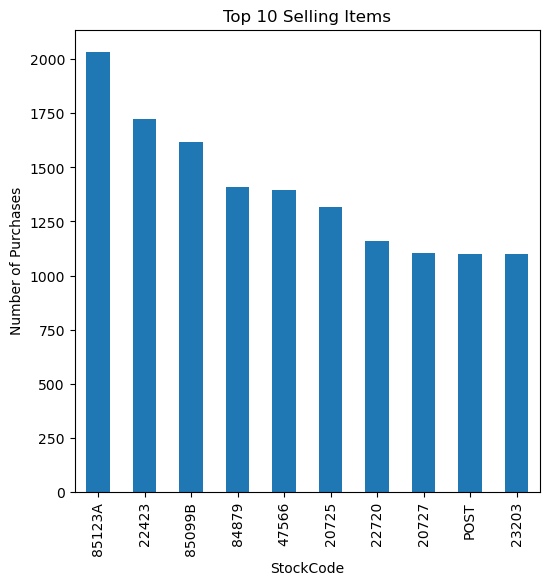

In [193]:
# Visualize top-selling items
top_selling_items = purchases_per_item.sort_values(ascending=False).head(10)
f, ax = plt.subplots(1,1, figsize=(6, 6))
top_selling_items.plot(kind='bar')
ax.set_title('Top 10 Selling Items')
ax.set_xlabel('StockCode')
ax.set_ylabel('Number of Purchases')

# Print corresponding Description for each StockCode
for stock_code in top_selling_items.index:
    description = cleaned_retail_data[cleaned_retail_data['StockCode'] == stock_code]['Description'].iloc[0]
    print(f'StockCode: {stock_code}, Description: {description}')

Text(0, 0.5, 'Number of Purchases')

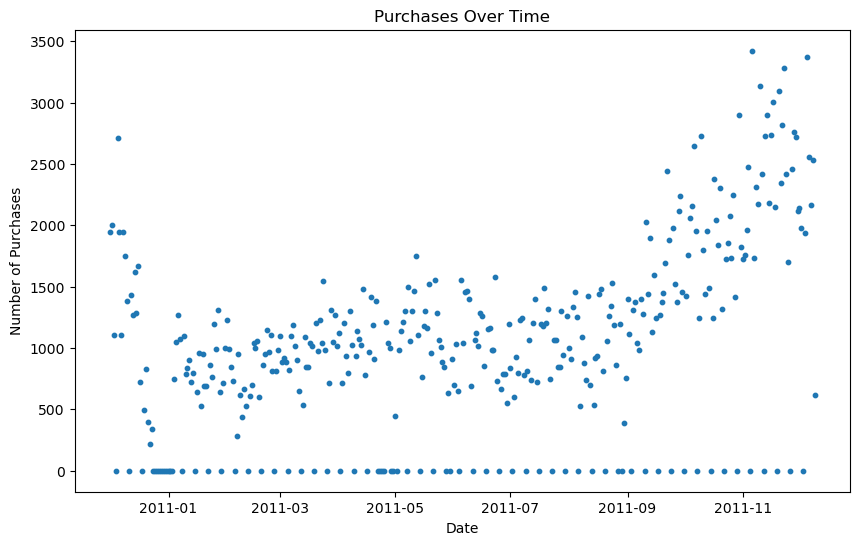

In [194]:
# Visualize purchase trends over time
purchases_over_time = cleaned_retail_data.set_index('InvoiceDate').resample('D').size()
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax.scatter(purchases_over_time.index, purchases_over_time.values, s=10)
ax.set_title('Purchases Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Purchases')

We notice a spike around November / December + some days with 0 purchases

In [195]:
# Seems like we got a lot of 0 purchases on certain days. Let's investigate
zero_purchase_days = purchases_over_time[purchases_over_time == 0]
print(f'Number of days with zero purchases: {zero_purchase_days.shape[0]:3d}')
print(f'Days with zero purchases: {zero_purchase_days.index}')

Number of days with zero purchases:  69
Days with zero purchases: DatetimeIndex(['2010-12-04', '2010-12-11', '2010-12-18', '2010-12-24',
               '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01',
               '2011-01-02', '2011-01-03', '2011-01-08', '2011-01-15',
               '2011-01-22', '2011-01-29', '2011-02-05', '2011-02-12',
               '2011-02-19', '2011-02-26', '2011-03-05', '2011-03-12',
               '2011-03-19', '2011-03-26', '2011-04-02', '2011-04-09',
               '2011-04-16', '2011-04-22', '2011-04-23', '2011-04-24',
               '2011-04-25', '2011-04-29', '2011-04-30', '2011-05-02',
               '2011-05-07', '2011-05-14', '2011-05-21', '2011-05-28',
               '2011-05-30', '2011-06-04', '2011-06-11', '2011-06-18',
               '2011-06-25', '2011-07-02', '2011-07-09', '2011-07-16',
               '2011-07-23', '2011-07-30', '2011-08-06', '2011-08-13',
           

Text(0, 0.5, 'Number of Purchases')

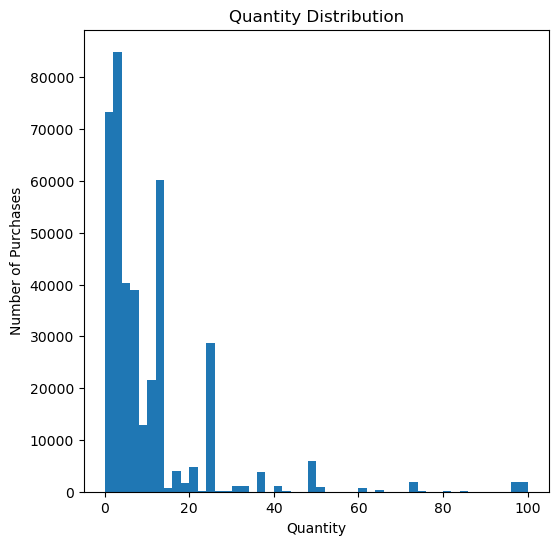

In [196]:
# Look at quantity distributions
f, ax = plt.subplots(1,1, figsize=(6, 6))
ax.hist(cleaned_retail_data['Quantity'], bins=50, range=(0, 100))
ax.set_title('Quantity Distribution')
ax.set_xlabel('Quantity')
ax.set_ylabel('Number of Purchases')

Most customers buy only a few units per transaction, but few transactions involve very large quantities

Look for seasonality or patterns by month/week/day


/var/folders/gn/kmp970g50zgf_030nc9dcr5m0000gn/T/ipykernel_40546/1670157243.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = cleaned_retail_data.resample('M', on='InvoiceDate').size()


Text(0, 0.5, 'Number of Purchases')

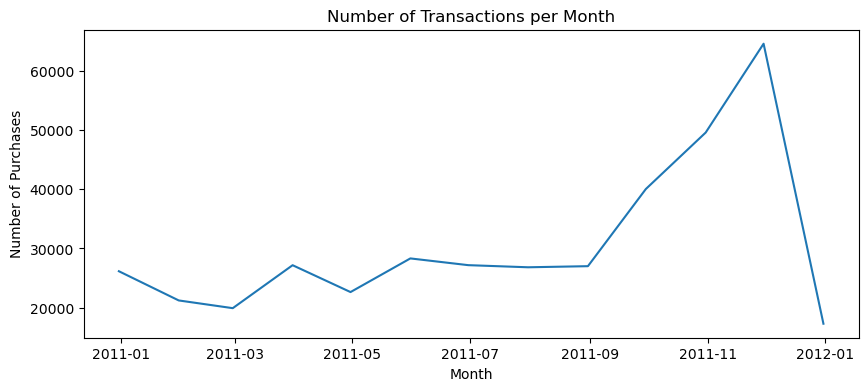

In [197]:
# Creating time-based features
cleaned_retail_data['Year'] = cleaned_retail_data['InvoiceDate'].dt.year
cleaned_retail_data['Month'] = cleaned_retail_data['InvoiceDate'].dt.month
cleaned_retail_data['Week'] = cleaned_retail_data['InvoiceDate'].dt.isocalendar().week
cleaned_retail_data['DayOfWeek'] = cleaned_retail_data['InvoiceDate'].dt.dayofweek  # Monday=0
cleaned_retail_data['Hour'] = cleaned_retail_data['InvoiceDate'].dt.hour

# Look for monthly seasonality
monthly_counts = cleaned_retail_data.resample('M', on='InvoiceDate').size()
plt.figure(figsize=(10,4))
plt.plot(monthly_counts.index, monthly_counts.values)
plt.title('Number of Transactions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')

/var/folders/gn/kmp970g50zgf_030nc9dcr5m0000gn/T/ipykernel_40546/355485069.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = cleaned_retail_data.resample('M', on='InvoiceDate')['TotalPrice'].sum()


Text(0, 0.5, 'Revenue (£)')

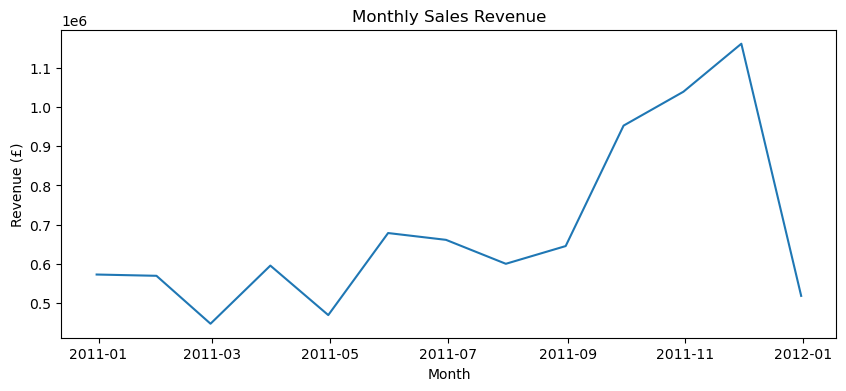

In [198]:
# Look at sales revenue instead
cleaned_retail_data['TotalPrice'] = cleaned_retail_data['Quantity'] * cleaned_retail_data['UnitPrice']

monthly_sales = cleaned_retail_data.resample('M', on='InvoiceDate')['TotalPrice'].sum()

plt.figure(figsize=(10,4))
plt.plot(monthly_sales.index, monthly_sales.values)
plt.title('Monthly Sales Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')

Clear seasonal pattern: spike around November / December = holiday season

Text(0, 0.5, 'Revenue (£)')

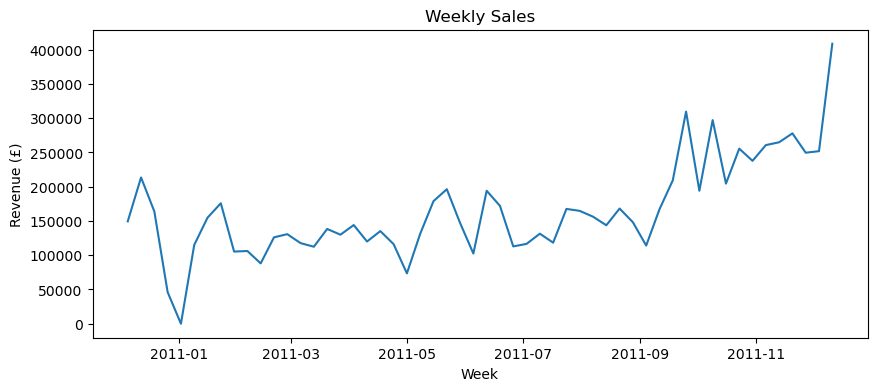

In [199]:
# Look for weekly trends
weekly_sales = cleaned_retail_data.resample('W', on='InvoiceDate')['TotalPrice'].sum()
plt.figure(figsize=(10,4))
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title('Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Revenue (£)')

Text(0, 0.5, 'Revenue (£)')

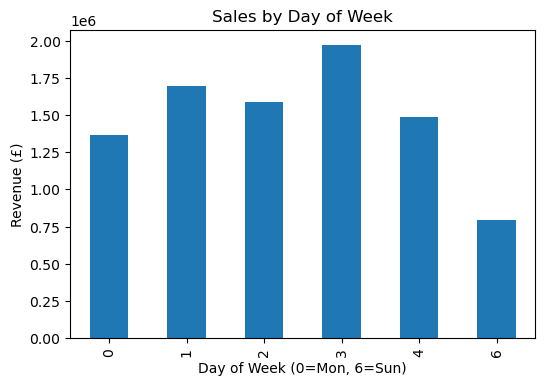

In [200]:
day_of_week_sales = cleaned_retail_data.groupby('DayOfWeek')['TotalPrice'].sum()

plt.figure(figsize=(6,4))
day_of_week_sales.plot(kind='bar')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Revenue (£)')

Feature Engineering

In [201]:
# Encode categorical features: StockCode, Country
cleaned_retail_data['StockCode'] = cleaned_retail_data['StockCode'].astype('category').cat.codes
cleaned_retail_data['Country'] = cleaned_retail_data['Country'].astype('category').cat.codes

In [202]:
cleaned_retail_data.head()

InvoiceNo  StockCode                          Description  Quantity  \
0     536365       3233   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365       2643                  WHITE METAL LANTERN         6   
2     536365       2847       CREAM CUPID HEARTS COAT HANGER         8   
3     536365       2795  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365       2794       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID  Country  TotalPrice  Year  \
0 2010-12-01 08:26:00       2.55       17850       35       15.30  2010   
1 2010-12-01 08:26:00       3.39       17850       35       20.34  2010   
2 2010-12-01 08:26:00       2.75       17850       35       22.00  2010   
3 2010-12-01 08:26:00       3.39       17850       35       20.34  2010   
4 2010-12-01 08:26:00       3.39       17850       35       20.34  2010   

   Month  Week  DayOfWeek  Hour  
0     12    48          2     8  
1     12    48          2     8  
2     12    48          2     8  
3     12    48          2     8  
4     12    48          2     8

In [203]:
# User features: total purchases, average basket size, recency (days since last purchase)
user_total_purchases = cleaned_retail_data.groupby('CustomerID').size()
user_avg_basket_size = cleaned_retail_data.groupby('CustomerID')['Quantity'].mean()
last_purchase_date = cleaned_retail_data.groupby('CustomerID')['InvoiceDate'].max()
recency_days = (cleaned_retail_data['InvoiceDate'].max() - last_purchase_date).dt.days

# Item features: total sold, average price, popularity (number of unique buyers)
item_total_sold = cleaned_retail_data.groupby('StockCode')['Quantity'].sum()
item_avg_price = cleaned_retail_data.groupby('StockCode')['UnitPrice'].mean()
item_popularity = cleaned_retail_data.groupby('StockCode')['CustomerID'].nunique()

# User-Item interaction features: purchase frequency, last purchase gap
user_item_purchase_freq = cleaned_retail_data.groupby(['CustomerID', 'StockCode']).size()
last_purchase = cleaned_retail_data.groupby(['CustomerID', 'StockCode'])['InvoiceDate'].max()
last_purchase_gap = (cleaned_retail_data['InvoiceDate'].max() - last_purchase).dt.days

In [204]:
# Map features back to the main dataframe
full_retail_data = cleaned_retail_data.copy()

# User features need to be mapped by CustomerID
full_retail_data['user_total_purchases'] = full_retail_data['CustomerID'].map(user_total_purchases)
full_retail_data['user_avg_basket_size'] = full_retail_data['CustomerID'].map(user_avg_basket_size)
full_retail_data['recency_days'] = full_retail_data['CustomerID'].map(recency_days)

# Item features need to be mapped by StockCode
full_retail_data['item_total_sold'] = full_retail_data['StockCode'].map(item_total_sold)
full_retail_data['item_avg_price'] = full_retail_data['StockCode'].map(item_avg_price)
full_retail_data['item_popularity'] = full_retail_data['StockCode'].map(item_popularity)

# User-item interaction features need to be mapped by (CustomerID, StockCode), so we need to use a MultiIndex map
# Convert MultiIndex Series to dict for mapping
user_item_freq_dict = user_item_purchase_freq.to_dict()
last_purchase_gap_dict = last_purchase_gap.to_dict()
# Map using tuple keys
full_retail_data['user_item_purchase_freq'] = full_retail_data.apply(
    lambda row: user_item_freq_dict.get((row['CustomerID'], row['StockCode']), 0), axis=1)
full_retail_data['last_purchase_gap'] = full_retail_data.apply(
    lambda row: last_purchase_gap_dict.get((row['CustomerID'], row['StockCode']), recency_days.max()), axis=1)

In [205]:
full_retail_data.head()

InvoiceNo  StockCode                          Description  Quantity  \
0     536365       3233   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365       2643                  WHITE METAL LANTERN         6   
2     536365       2847       CREAM CUPID HEARTS COAT HANGER         8   
3     536365       2795  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365       2794       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID  Country  TotalPrice  Year  ...  \
0 2010-12-01 08:26:00       2.55       17850       35       15.30  2010  ...   
1 2010-12-01 08:26:00       3.39       17850       35       20.34  2010  ...   
2 2010-12-01 08:26:00       2.75       17850       35       22.00  2010  ...   
3 2010-12-01 08:26:00       3.39       17850       35       20.34  2010  ...   
4 2010-12-01 08:26:00       3.39       17850       35       20.34  2010  ...   

   DayOfWeek  Hour  user_total_purchases  user_avg_basket_size  recency_days  \
0          2     8                   297              5.835017           371   
1          2     8                   297              5.835017           371   
2          2     8                   297              5.835017           371   
3          2     8                   297              5.835017           371   
4          2     8                   297              5.835017           371   

   item_total_sold  item_avg_price  item_popularity  user_item_purchase_freq  \
0            36782        2.893106              856                       17   
1             1639        3.768403              149                       17   
2             1918        3.816311              133                       15   
3             2469        4.001595              211                       17   
4             3707        4.054756              228                       17   

   last_purchase_gap  
0                371  
1                371  
2                371  
3                371  
4                371  

[5 rows x 22 columns]

In [207]:
full_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   InvoiceNo                397924 non-null  int64         
 1   StockCode                397924 non-null  int16         
 2   Description              397924 non-null  object        
 3   Quantity                 397924 non-null  int64         
 4   InvoiceDate              397924 non-null  datetime64[ns]
 5   UnitPrice                397924 non-null  float64       
 6   CustomerID               397924 non-null  int64         
 7   Country                  397924 non-null  int8          
 8   TotalPrice               397924 non-null  float64       
 9   Year                     397924 non-null  int32         
 10  Month                    397924 non-null  int32         
 11  Week                     397924 non-null  UInt32        
 12  DayOfWeek            

Baseline Model

Goal: predict the purchase likelihood for user-item pairs

First we will try a simple logistic regression model

This won't work: the target should be binary however for now we only have positive samples, so we need to generate some negative ones

In [219]:
# Add target to positive purchases
full_retail_data['y'] = 1

# Define features to use
feature_cols = [
    'user_total_purchases', 'user_avg_basket_size', 'recency_days',
    'item_total_sold', 'item_avg_price', 'item_popularity',
    'user_item_purchase_freq', 'last_purchase_gap',
    'Year', 'Month', 'Week', 'DayOfWeek', 'Hour',
    'StockCode', 'Country'
]

# Keep only features + target
pos_samples = full_retail_data[feature_cols + ['y']].copy()

Generate negative samples by randomly pairing users with items they haven't purchased


In [220]:
# Unique users and items
users = full_retail_data['CustomerID'].unique()
items = full_retail_data['StockCode'].unique()

# Sample negative pairs equal in size to positive samples
n_neg = len(pos_samples)
neg_user_item = pd.DataFrame({
    'CustomerID': np.random.choice(users, n_neg),
    'StockCode': np.random.choice(items, n_neg)
})

# Remove existing positive pairs
neg_user_item = neg_user_item.merge(
    full_retail_data[['CustomerID','StockCode']],
    on=['CustomerID','StockCode'],
    how='left',
    indicator=True
)
neg_user_item = neg_user_item[neg_user_item['_merge']=='left_only'].drop(columns=['_merge'])
neg_user_item['y'] = 0

Then map features to negative samples

In [221]:
# User features
for col in ['user_total_purchases','user_avg_basket_size','recency_days']:
    neg_user_item[col] = neg_user_item['CustomerID'].map(
        full_retail_data.drop_duplicates('CustomerID').set_index('CustomerID')[col]
    )

# Item features
for col in ['item_total_sold','item_avg_price','item_popularity']:
    neg_user_item[col] = neg_user_item['StockCode'].map(
        full_retail_data.drop_duplicates('StockCode').set_index('StockCode')[col]
    )

# User-item interaction features
neg_user_item['user_item_purchase_freq'] = 0
neg_user_item['last_purchase_gap'] = neg_user_item['CustomerID'].map(
    full_retail_data.drop_duplicates('CustomerID').set_index('CustomerID')['recency_days']
)

# Time features: set to median or arbitrary placeholder
for col in ['Year','Month','Week','DayOfWeek','Hour','Country']:
    neg_user_item[col] = full_retail_data[col].median()  # or another default

And finally combine positive and negative samples

In [222]:
model_data = pd.concat([pos_samples, neg_user_item[feature_cols + ['y']]], ignore_index=True)
X = model_data[feature_cols]
y = model_data['y']

Now the target y has both 0s and 1s, so we're ready for train/test split

In [223]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 20% test size, stratify to maintain class balance

# Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

And defining / training the model

In [224]:
# Baseline model: Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [225]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

/Users/adupuy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/adupuy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Evaluating trained model

In [ ]:
# AUC (area under ROC curve): 0.5 is random, 1.0 is perfect
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")

# Accuracy: fraction of correct predictions
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision at top k: fraction of true positives in top k predicted probabilities
def precision_at_k(y_true, y_proba, k=1000):
    # Sort by predicted probability
    idx = np.argsort(y_proba)[::-1][:k]
    top_k_true = y_true.iloc[idx]
    return top_k_true.sum() / k  # fraction of positives in top k

p_at_1000 = precision_at_k(y_test.reset_index(drop=True), pd.Series(y_proba), k=1000)
print(f"Precision@1000: {p_at_1000:.4f}")

AUC: 0.7214
Accuracy: 0.5760
Precision@1000: 0.9960


The model does a good job at identifying the most likely purchases, although accuracy is quite modest